In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
    
from pysgpp import ClassificationLearner, RegularGridConfiguration, \
AdpativityConfiguration, SLESolverConfiguration, RegularizationConfiguration, DataMatrix, \
DataVector
import numpy as np
import pandas as pd
import sklearn.preprocessing as pre
import sklearn.base
import sklearn.datasets
import sklearn.grid_search
from sklearn.cross_validation import ShuffleSplit

In [9]:
def to_data_matrix(arr):
    (size_x, size_y) = arr.shape
    matrix = DataMatrix(size_x, size_y)
    cur_row = 0
    for x in arr:
        x_vec = DataVector(x.tolist())
        matrix.setRow(cur_row,x_vec)
        cur_row += 1
    return matrix     
        
# http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator
class SGClassificationLearner(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, lambdaReg):
        self.lambdaReg = lambdaReg     

    def fit(self, X, y):
        
        grid_config = RegularGridConfiguration()
        grid_config.dim_ = X.shape[1]
        grid_config.level_ = 3
        grid_config.type_ = 6 #ModLinear

        adaptivity_config = AdpativityConfiguration()
        adaptivity_config.noPoints_ = 0
        adaptivity_config.numRefinements_ = 0

        solver_config = SLESolverConfiguration()
        solver_config.type_ = 0 # CG
        solver_config.maxIterations_ = 500
        solver_config.eps_ = 1e-6

        regularization_config = RegularizationConfiguration()
        regularization_config.exponentBase = 0.25
        regularization_config.type_ = 2 # diagonal
        regularization_config.lambda_ = self.lambdaReg
        self._learner = ClassificationLearner(grid_config, adaptivity_config, solver_config, regularization_config)
        
        X_mat = to_data_matrix(X)
        y_vec = DataVector(y.tolist())
        self._learner.train(X_mat, y_vec)
            
    def predict(self, X):
        X_mat = to_data_matrix(X)
        result = self._learner.predict(X_mat)
        return result.array()
    
    def score(self, X, y, sample_weight=None):
        X_mat = to_data_matrix(X)
        y_vec = DataVector(y.tolist())
        return self._learner.getAccuracy(X_mat, y_vec)

In [10]:
df = pd.read_csv("../datasets/processed/yeast/yeast_prep.csv")
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,category
0,0.58,0.61,0.47,0.13,0.5,0,0.48,0.22,6
1,0.43,0.67,0.48,0.27,0.5,0,0.53,0.22,6
2,0.64,0.62,0.49,0.15,0.5,0,0.53,0.22,6
3,0.58,0.44,0.57,0.13,0.5,0,0.54,0.22,7
4,0.42,0.44,0.48,0.54,0.5,0,0.48,0.22,6


In [11]:
df.describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,category
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199,4.126011
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491,3.037575
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000,0.000000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000,5.000000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000,9.000000


In [12]:
X = np.array(df.ix[:,0:-1])
y = df.ix[:,-1]

In [13]:
learner = SGClassificationLearner(42)
cv = ShuffleSplit(X.shape[0], random_state=42)
parameters = {"lambdaReg": np.logspace(10, -10, num=10)}
gridSearch = sklearn.grid_search.GridSearchCV(learner, parameters, cv=cv, verbose=1, n_jobs=4)

In [14]:
gridSearch.fit(X,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done  94 out of 100 | elapsed: 16.4min remaining:  1.0min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 20.3min finished


GridSearchCV(cv=ShuffleSplit(1484, n_iter=10, test_size=0.1, random_state=42),
       error_score='raise',
       estimator=SGClassificationLearner(lambdaReg=42), fit_params={},
       iid=True, loss_func=None, n_jobs=4,
       param_grid={'lambdaReg': array([  1.00000e+10,   5.99484e+07,   3.59381e+05,   2.15443e+03,
         1.29155e+01,   7.74264e-02,   4.64159e-04,   2.78256e-06,
         1.66810e-08,   1.00000e-10])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [15]:
scores = gridSearch.grid_scores_
grid_params,grid_mean, grid_std = zip(*scores)
grid_mean = ([x for x in grid_mean])
grid_lambdas = [x["lambdaReg"] for x in grid_params]

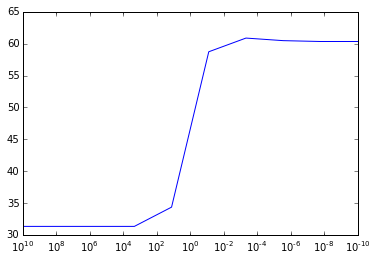

In [16]:
plt.errorbar(grid_lambdas, grid_mean)
plt.xscale('log')
plt.gca().invert_xaxis()

In [17]:
gridSearch.grid_scores_

[mean: 31.34228, std: 3.76138, params: {'lambdaReg': 10000000000.0},
 mean: 31.34228, std: 3.76138, params: {'lambdaReg': 59948425.031894088},
 mean: 31.34228, std: 3.76138, params: {'lambdaReg': 359381.36638046254},
 mean: 31.34228, std: 3.76138, params: {'lambdaReg': 2154.4346900318824},
 mean: 34.36242, std: 4.58935, params: {'lambdaReg': 12.915496650148826},
 mean: 58.72483, std: 4.04080, params: {'lambdaReg': 0.077426368268112777},
 mean: 60.87248, std: 3.85600, params: {'lambdaReg': 0.00046415888336127724},
 mean: 60.46980, std: 3.87231, params: {'lambdaReg': 2.7825594022071145e-06},
 mean: 60.33557, std: 3.87231, params: {'lambdaReg': 1.6681005372000556e-08},
 mean: 60.33557, std: 3.87231, params: {'lambdaReg': 1e-10}]